In [9]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap
import datetime
from datetime import date
import re
import squarify

In [153]:
data = pd.read_csv('data.csv')

In [154]:
data['Date'] = pd.to_datetime(data['Date'])

In [155]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

In [156]:
data = data[(data["year"]>2014)&(data['year']<2018)]

In [157]:
data.to_csv('data1517.csv')

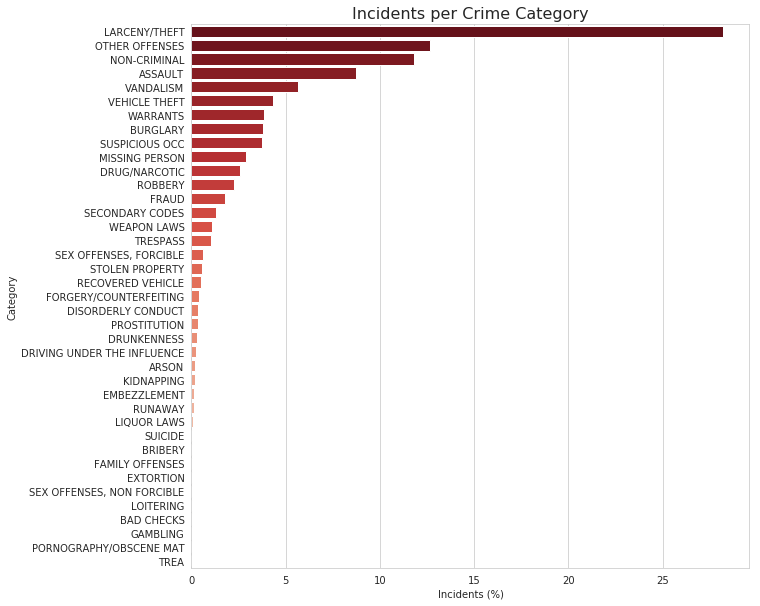

In [7]:
overview = data.groupby('Category').count().iloc[:, 0].sort_values(
    ascending=False)
#overview = overview.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (overview.values / overview.values.sum()) * 100,
        overview.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()
#ref
#https://www.kaggle.com/yannisp/sf-crime-analysis-prediction#Methodology

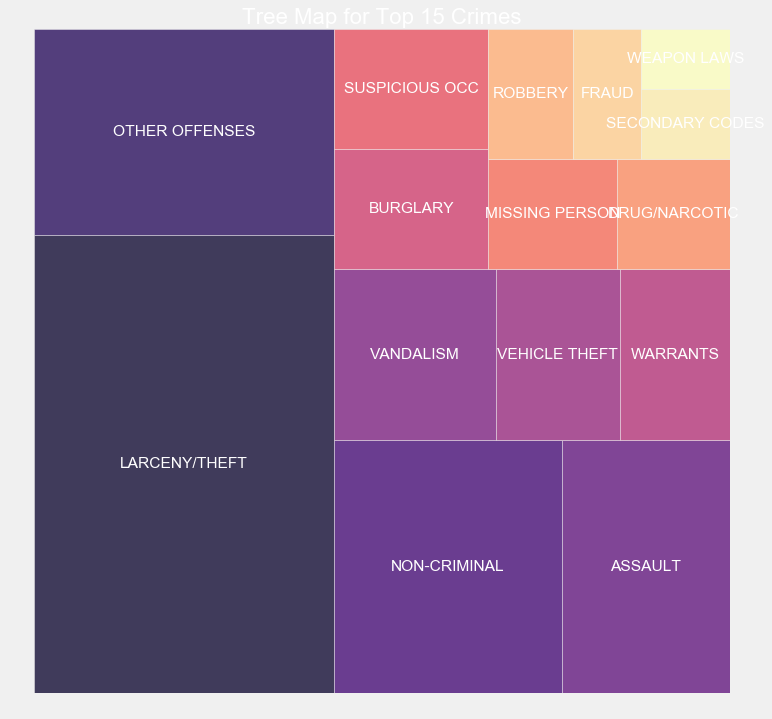

In [166]:
# plotting a tree map
plt.style.use('dark_background')
y = data['Category'].value_counts().head(15)
    
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fivethirtyeight')

color = plt.cm.magma(np.linspace(0.1, 6, 90))
squarify.plot(sizes = y.values, label = y.index, alpha=.8, color = color)
plt.title('Tree Map for Top 15 Crimes', fontsize = 20)

plt.axis('off')
plt.show()
#ref
#https://www.kaggle.com/roshansharma/sanfrancisco-crime-analysis

In [ ]:
##于是就愉快地predict larceny/theft吧！

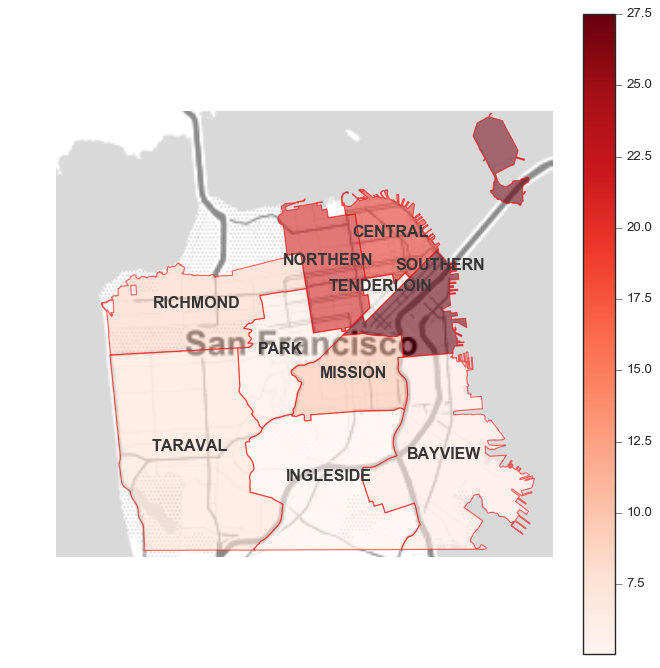

In [58]:
theft = data[data["Category"] == 'LARCENY/THEFT']

theft

# Downloading the shapefile of the area 
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    theft.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
theft_days = theft.groupby('Date').count().shape[0]


pd_districts['inc_per_day'] = pd_districts.IncidntNum/theft_days

# Ploting the data
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()
#ref
#https://www.kaggle.com/yannisp/sf-crime-analysis-prediction#Methodology

pd_districts

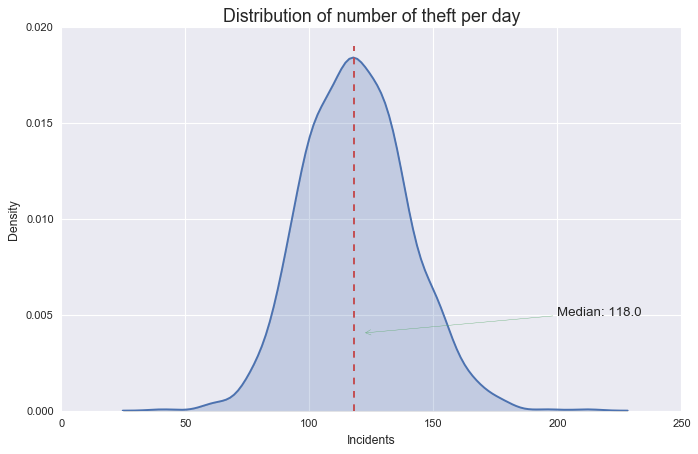

In [128]:
col = sns.color_palette()
#theft['Time'] = pd.to_datetime(data['Time'])
#theft['Date'] = theft.Date.dt.date
#theft['Date'] = theft['Date'].values.astype(string)
theft['Hour'] = theft.Time.dt.hour

plt.figure(figsize=(10, 6))
data = theft.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data = data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[2])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of theft per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

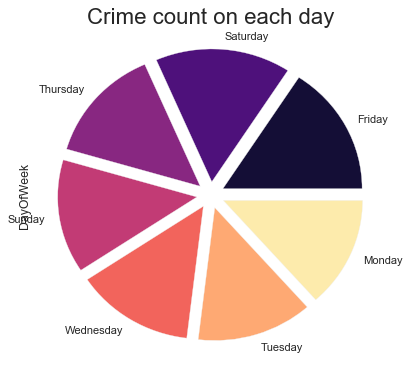

In [174]:
plt.style.use('seaborn')
color = plt.cm.magma(np.linspace(0.1, 10, 70))
#color = plt.cm.spring(np.linspace(0, 3, 17))
theft['DayOfWeek'].value_counts().plot.pie(figsize = (5, 5), explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1), colors = color)

plt.title('Crime count on each day',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

In [219]:
theft

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,year,month,day,Hour
24,150105809,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Tuesday,2015-02-03,2019-12-07 19:00:00,NORTHERN,NONE,2100 Block of LOMBARD ST,-122.436910,37.799853,POINT (-122.436910088417 37.7998528145322),15010580906243,2015,2,3,19
25,150098759,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Saturday,2015-01-31,2019-12-07 17:20:00,SOUTHERN,NONE,400 Block of 10TH ST,-122.410541,37.770913,POINT (-122.410541166987 37.7709130566165),15009875906243,2015,1,31,17
29,150109845,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,2015-02-04,2019-12-07 21:45:00,SOUTHERN,NONE,TOWNSEND ST / LUSK AL,-122.393859,37.777977,POINT (-122.393859499886 37.7779770738329),15010984506244,2015,2,4,21
31,150106885,LARCENY/THEFT,PETTY THEFT BICYCLE,Tuesday,2015-02-03,2019-12-07 19:00:00,CENTRAL,NONE,1300 Block of WASHINGTON ST,-122.415435,37.793946,POINT (-122.415434713819 37.7939455886301),15010688506313,2015,2,3,19
40,150107708,LARCENY/THEFT,GRAND THEFT FROM PERSON,Tuesday,2015-02-03,2019-12-07 20:00:00,TENDERLOIN,NONE,OFARRELL ST / JONES ST,-122.412971,37.785788,POINT (-122.412970537591 37.7857883766888),15010770806153,2015,2,3,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214997,176117955,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2017-05-05,2019-12-07 14:55:00,CENTRAL,NONE,0 Block of WINTER PL,-122.412069,37.799706,POINT (-122.41206946606533 37.79970641335905),17611795506372,2017,5,5,14
2215007,160964372,LARCENY/THEFT,GRAND THEFT FROM PERSON,Sunday,2016-11-27,2019-12-07 11:08:00,CENTRAL,NONE,MASON ST / GEARY ST,-122.409877,37.787149,POINT (-122.40987662253222 37.78714880797902),16096437206153,2016,11,27,11
2215015,160511161,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Friday,2016-06-24,2019-12-07 10:10:00,TARAVAL,NONE,500 Block of JUDAH ST,-122.467791,37.762008,POINT (-122.46779091121964 37.76200811098795),16051116106372,2016,6,24,10
2215017,160442986,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,2016-05-30,2019-12-07 19:10:00,CENTRAL,NONE,BAY ST / POWELL ST,-122.411953,37.805824,POINT (-122.41195308361146 37.80582429492737),16044298606244,2016,5,30,19


In [214]:
mth_cnt = theft.groupby('month', as_index = False).count()


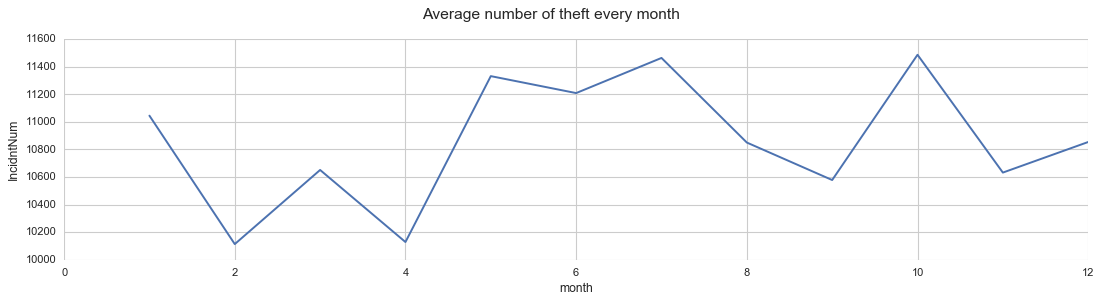

In [216]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.lineplot(x='month', y='IncidntNum', data=mth_cnt)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.suptitle('Average number of theft every month')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

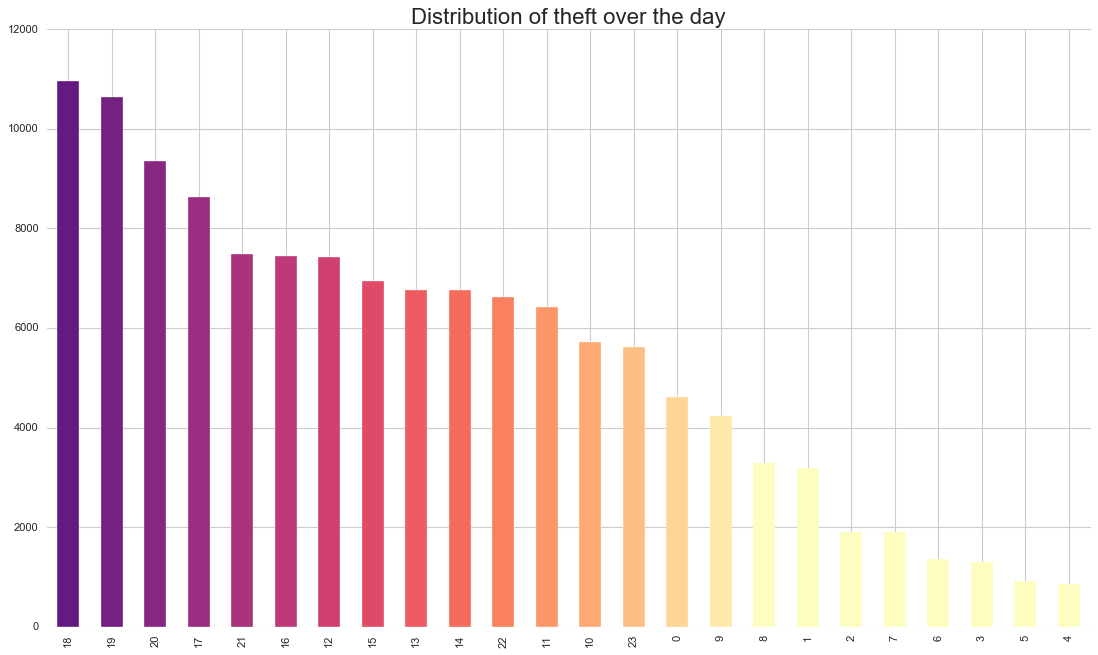

In [220]:
# checking the time at which crime occurs mostly

#import warnings
#warnings.filterwarnings('ignore')
color = plt.cm.magma(np.linspace(0.3, 2, 40))
#color = plt.cm.spring(np.linspace(0, 5, 100))
theft['Hour'].value_counts().head(24).plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of theft over the day', fontsize = 20)
plt.show()